# Analysis of NGINX Server Logs Using Deep Learning Clustering DBSCAN for DDOS Detection

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import cupy as cp
import warnings
import re

In [2]:
file_path = "old.log"

data=[]

In [3]:
def find_headers(file_path):
    headers = set()
    with open(file_path, "r") as file:
        for line in file:
            if line.strip().startswith("#") or "header" in line.lower():
                headers.add(line.strip())
            if len(headers) > 20:
                break
    return headers

In [ ]:
headers = find_headers(file_path)
print("Headers :")
for header in headers:
    print(header)

# Output censored

In [5]:
log_pattern = (
    r'(?P<ip>(\d{1,3}(\.\d{1,3}){3})|([a-fA-F0-9:.]+)) - '
    r'(?P<user>[^ ]+) \[(?P<timestamp>[^\]]+)\] '
    r'"(?P<request>[^"]+)" (?P<status_code>\d{3}) (?P<bytes_sent>\d+) '
    r'"(?P<referrer>[^"]*)" "(?P<user_agent>[^"]*)"'
)

with open(file_path, "r") as file:
    for line in file:
        match = re.search(log_pattern, line.strip())
        if match:
            ip = match.group("ip")
            ip_type = "IPv4" if "." in ip else "IPv6"
            
            data.append({
                "IP Address": ip,
                "IP Type": ip_type,
                "Timestamp": match.group("timestamp"),
                "Request": match.group("request"),
                "Status Code": match.group("status_code"),
                "Bytes Sent": match.group("bytes_sent"),
                "Referrer": match.group("referrer"),
                "User Agent": match.group("user_agent"),
            })
        else:
            print(f"Line does not match: {line}")

Line does not match: 10.200.7.2 - Ruli ITTS [19/Jan/2023:16:04:12 +0700] "POST /AutoDiscover/AutoDiscover.xml HTTP/1.0" 404 104284 "-" "microsoft.windowscommunicationsapps"

Line does not match: 103.130.167.229 - Salsabila Felda [17/Mar/2023:19:10:44 +0700] "POST /AutoDiscover/AutoDiscover.xml HTTP/1.0" 404 117646 "-" "microsoft.windowscommunicationsapps"

Line does not match: 103.130.167.229 - Salsabila Felda [17/Mar/2023:19:11:03 +0700] "POST /AutoDiscover/AutoDiscover.xml HTTP/1.0" 404 117646 "-" "microsoft.windowscommunicationsapps"

Line does not match: 103.130.167.229 - Salsabila Felda [17/Mar/2023:19:12:01 +0700] "POST /AutoDiscover/AutoDiscover.xml HTTP/1.0" 404 117646 "-" "microsoft.windowscommunicationsapps"

Line does not match: 103.130.167.229 - Salsabila Felda [17/Mar/2023:19:12:06 +0700] "POST /AutoDiscover/AutoDiscover.xml HTTP/1.0" 404 117646 "-" "microsoft.windowscommunicationsapps"

Line does not match: 52.214.208.39 - Student Attendance System using QR Codes (Case St

In [6]:
df = pd.DataFrame(data)
df

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent
0,66.249.79.63,IPv4,16/Dec/2022:17:04:10 +0700,GET /robots.txt HTTP/1.0,404,146,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
1,10.220.34.198,IPv4,16/Dec/2022:17:04:12 +0700,GET / HTTP/1.0,200,138,-,Mozilla/5.0 (compatible; PRTG Network Monitor ...
2,10.220.34.198,IPv4,16/Dec/2022:17:05:16 +0700,GET / HTTP/1.0,200,665508,-,Mozilla/5.0 (compatible; PRTG Network Monitor ...
3,114.5.105.122,IPv4,16/Dec/2022:17:06:07 +0700,GET / HTTP/1.0,200,665508,-,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...
4,114.5.105.122,IPv4,16/Dec/2022:17:06:08 +0700,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444,https://ittelkom-sby.ac.id/,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...
...,...,...,...,...,...,...,...,...
11365487,10.220.5.92,IPv4,17/Sep/2024:07:41:14 +0700,GET /robots.txt HTTP/1.0,200,176,-,Mozilla/5.0 (compatible;PetalBot;+https://webm...
11365488,10.220.5.92,IPv4,17/Sep/2024:07:45:28 +0700,GET / HTTP/1.0,301,162,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
11365489,10.220.5.92,IPv4,17/Sep/2024:07:50:28 +0700,GET / HTTP/1.0,200,138,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
11365490,10.220.5.92,IPv4,17/Sep/2024:07:55:28 +0700,HEAD / HTTP/1.0,200,0,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...


In [7]:
def device_type(params1):
    if 'Mobile' in params1 or 'IPhone' in params1 or 'Android' in params1:
        return 'Smartphone'
    else:
        return 'PC'
    
df['Device'] = df['User Agent'].apply(device_type)
df

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device
0,66.249.79.63,IPv4,16/Dec/2022:17:04:10 +0700,GET /robots.txt HTTP/1.0,404,146,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,PC
1,10.220.34.198,IPv4,16/Dec/2022:17:04:12 +0700,GET / HTTP/1.0,200,138,-,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC
2,10.220.34.198,IPv4,16/Dec/2022:17:05:16 +0700,GET / HTTP/1.0,200,665508,-,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC
3,114.5.105.122,IPv4,16/Dec/2022:17:06:07 +0700,GET / HTTP/1.0,200,665508,-,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Smartphone
4,114.5.105.122,IPv4,16/Dec/2022:17:06:08 +0700,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444,https://ittelkom-sby.ac.id/,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Smartphone
...,...,...,...,...,...,...,...,...,...
11365487,10.220.5.92,IPv4,17/Sep/2024:07:41:14 +0700,GET /robots.txt HTTP/1.0,200,176,-,Mozilla/5.0 (compatible;PetalBot;+https://webm...,PC
11365488,10.220.5.92,IPv4,17/Sep/2024:07:45:28 +0700,GET / HTTP/1.0,301,162,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC
11365489,10.220.5.92,IPv4,17/Sep/2024:07:50:28 +0700,GET / HTTP/1.0,200,138,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC
11365490,10.220.5.92,IPv4,17/Sep/2024:07:55:28 +0700,HEAD / HTTP/1.0,200,0,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC


In [8]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
df['Referrer'].replace('-', np.nan, inplace=True)
df['Referrer'].isna()

0            True
1            True
2            True
3            True
4           False
            ...  
11365487     True
11365488    False
11365489    False
11365490    False
11365491    False
Name: Referrer, Length: 11365492, dtype: bool

In [10]:
null_pada_referrer = df['Referrer'].isna().sum()
null_pada_referrer

7371271

In [11]:
df['IP Address'] = df['IP Address'].str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
df['Delta Time'] = df.groupby('IP Address')['Timestamp'].diff()
df['Delta Time (Minutes)'] = df['Delta Time'].dt.total_seconds() / 60
df['Delta Time'].fillna(99999, inplace=True)
df['Delta Time (Minutes)'].fillna(99999, inplace=True)
df

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,Delta Time (Minutes)
0,66.249.79.63,IPv4,2022-12-16 17:04:10+07:00,GET /robots.txt HTTP/1.0,404,146,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,PC,99999,99999.000000
1,10.220.34.198,IPv4,2022-12-16 17:04:12+07:00,GET / HTTP/1.0,200,138,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,99999,99999.000000
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,1.066667
3,114.5.105.122,IPv4,2022-12-16 17:06:07+07:00,GET / HTTP/1.0,200,665508,NaN,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Smartphone,99999,99999.000000
4,114.5.105.122,IPv4,2022-12-16 17:06:08+07:00,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444,https://ittelkom-sby.ac.id/,Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...,Smartphone,0 days 00:00:01,0.016667
...,...,...,...,...,...,...,...,...,...,...,...
11365487,10.220.5.92,IPv4,2024-09-17 07:41:14+07:00,GET /robots.txt HTTP/1.0,200,176,NaN,Mozilla/5.0 (compatible;PetalBot;+https://webm...,PC,0 days 00:00:46,0.766667
11365488,10.220.5.92,IPv4,2024-09-17 07:45:28+07:00,GET / HTTP/1.0,301,162,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC,0 days 00:04:14,4.233333
11365489,10.220.5.92,IPv4,2024-09-17 07:50:28+07:00,GET / HTTP/1.0,200,138,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC,0 days 00:05:00,5.000000
11365490,10.220.5.92,IPv4,2024-09-17 07:55:28+07:00,HEAD / HTTP/1.0,200,0,http://www.ittelkom-sby.ac.id,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,PC,0 days 00:05:00,5.000000


In [12]:
df['User Agent']

0           Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
1           Mozilla/5.0 (compatible; PRTG Network Monitor ...
2           Mozilla/5.0 (compatible; PRTG Network Monitor ...
3           Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...
4           Mozilla/5.0 (iPhone; CPU iPhone OS 16_1 like M...
                                  ...                        
11365487    Mozilla/5.0 (compatible;PetalBot;+https://webm...
11365488    Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
11365489    Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
11365490    Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
11365491    Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
Name: User Agent, Length: 11365492, dtype: object

In [13]:
tfidf = TfidfVectorizer(max_features=10)
user_agent_tfidf = tfidf.fit_transform(df['User Agent']).toarray()
user_agent_tfidf_gpu = cp.asarray(user_agent_tfidf, dtype=cp.float32)

user_agent_features = pd.DataFrame(cp.asnumpy(user_agent_tfidf_gpu), dtype='float32', columns=[f'UA_{i}' for i in range(user_agent_tfidf_gpu.shape[1])])
df = pd.concat([df.reset_index(drop=True), user_agent_features], axis=1)
df.columns

Index(['IP Address', 'IP Type', 'Timestamp', 'Request', 'Status Code',
       'Bytes Sent', 'Referrer', 'User Agent', 'Device', 'Delta Time',
       'Delta Time (Minutes)', 'UA_0', 'UA_1', 'UA_2', 'UA_3', 'UA_4', 'UA_5',
       'UA_6', 'UA_7', 'UA_8', 'UA_9'],
      dtype='object')

In [14]:
df.dtypes

IP Address                                 object
IP Type                                    object
Timestamp               datetime64[ns, UTC+07:00]
Request                                    object
Status Code                                object
Bytes Sent                                 object
Referrer                                   object
User Agent                                 object
Device                                     object
Delta Time                                 object
Delta Time (Minutes)                      float64
UA_0                                      float32
UA_1                                      float32
UA_2                                      float32
UA_3                                      float32
UA_4                                      float32
UA_5                                      float32
UA_6                                      float32
UA_7                                      float32
UA_8                                      float32


In [15]:
df_train = df.sample(n=500000, random_state=42)
df_train['Status Code'] = pd.to_numeric(df_train['Status Code'], errors='coerce')
df_train['Bytes Sent'] = df_train['Bytes Sent'].astype('float32')
df_train['Delta Time (Minutes)'] = df_train['Delta Time (Minutes)'].astype('float32')
features = ['Delta Time (Minutes)', 'Bytes Sent', 'Status Code'] + [f'UA_{i}' for i in range(user_agent_tfidf_gpu.shape[1])]
df_train.dtypes

IP Address                                 object
IP Type                                    object
Timestamp               datetime64[ns, UTC+07:00]
Request                                    object
Status Code                                 int64
Bytes Sent                                float32
Referrer                                   object
User Agent                                 object
Device                                     object
Delta Time                                 object
Delta Time (Minutes)                      float32
UA_0                                      float32
UA_1                                      float32
UA_2                                      float32
UA_3                                      float32
UA_4                                      float32
UA_5                                      float32
UA_6                                      float32
UA_7                                      float32
UA_8                                      float32


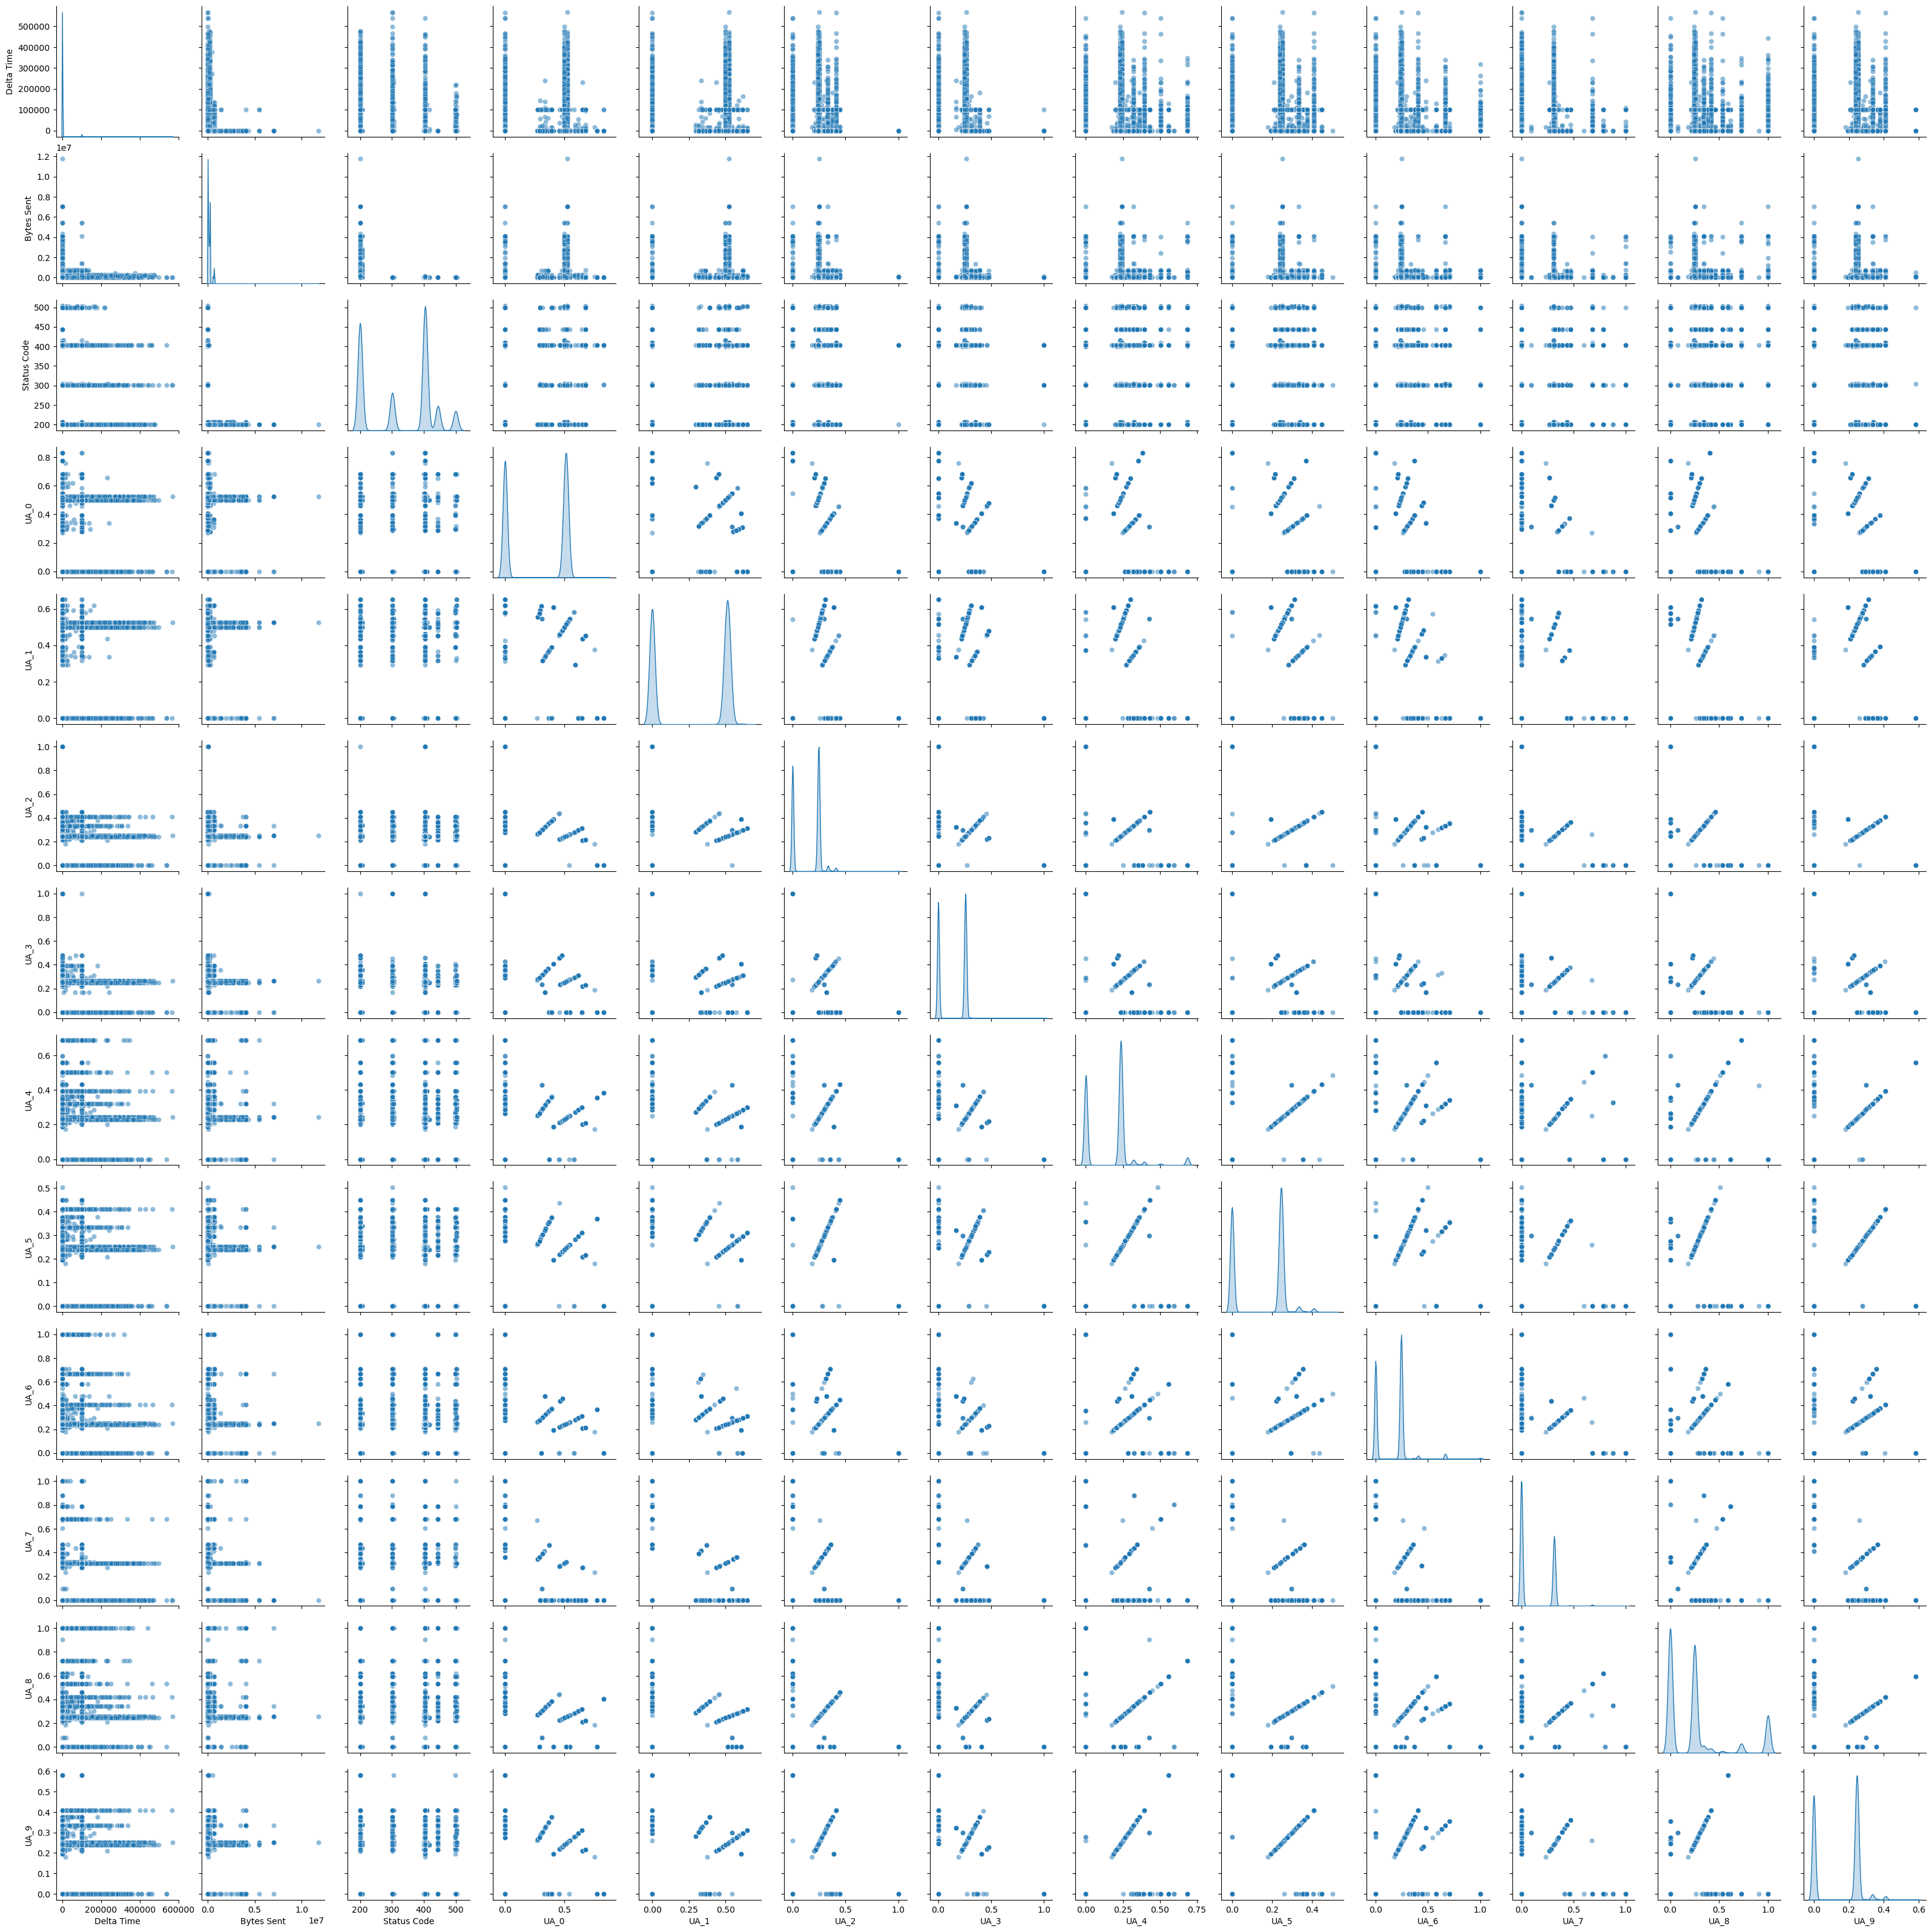

In [ ]:
Ip_address = df_train['IP Address']
Delta = df_train['Delta Time (Minutes)']
Bytes = df_train['Bytes Sent']
Status = df_train['Status Code']
Ua0 = df_train['UA_0']
Ua1 = df_train['UA_1']
Ua2 = df_train['UA_2']
Ua3 = df_train['UA_3'] 
Ua4 = df_train['UA_4'] 
Ua5 = df_train['UA_5'] 
Ua6 = df_train['UA_6'] 
Ua7 = df_train['UA_7']
Ua8 = df_train['UA_8']
Ua9 = df_train['UA_9']

data_plot = pd.DataFrame({
    'Delta Time': Delta,
    'Bytes Sent': Bytes,
    'Status Code': Status,
    'UA_0': Ua0,
    'UA_1': Ua1,
    'UA_2': Ua2,
    'UA_3': Ua3,
    'UA_4': Ua4,
    'UA_5': Ua5,
    'UA_6': Ua6,
    'UA_7': Ua7,
    'UA_8': Ua8,
    'UA_9': Ua9
})

sns.pairplot(data_plot, diag_kind='kde', plot_kws={'alpha':0.5})
plt.show()


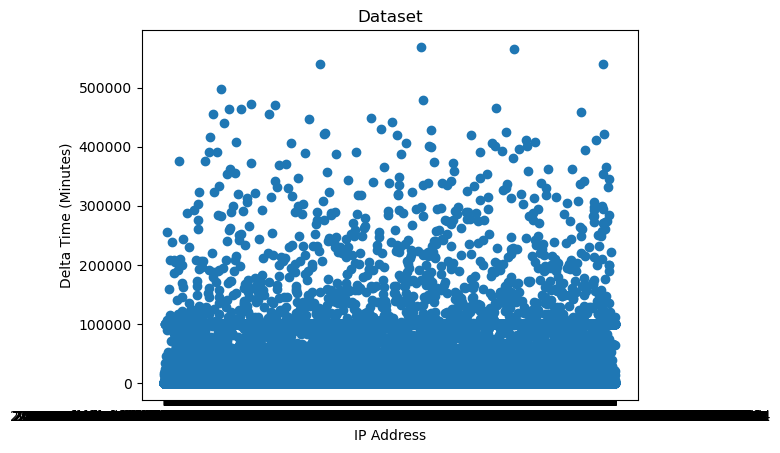

In [17]:
plt.scatter(Ip_address, Delta)
plt.xlabel('IP Address')
plt.ylabel('Delta Time (Minutes)')
plt.title('Dataset')
plt.show()

In [18]:
train_data_s, test_data_s = train_test_split(df_train, test_size=0.2, random_state=42)
features = ['Delta Time (Minutes)', 'Bytes Sent', 'Status Code'] + [f'UA_{i}' for i in range(user_agent_tfidf_gpu.shape[1])]

In [19]:
train_data = train_data_s.sort_values(by='Timestamp')
test_data = test_data_s.sort_values(by='Timestamp')
train_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_0,UA_1,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
13,66.249.79.63,IPv4,2022-12-16 17:07:46+07:00,GET /webinar-epic-culture-programs-program/ HT...,200,176587.0,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Smartphone,0 days 00:03:36,...,0.500771,0.499507,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470
23,10.220.34.198,IPv4,2022-12-16 17:10:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
78,10.220.34.199,IPv4,2022-12-16 17:11:36+07:00,GET /pendataan-pengiriman-jas-almamater/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/pendataan-pengirima...,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
182,10.220.34.199,IPv4,2022-12-16 17:13:49+07:00,GET /layanan-kemahasiswaan-dan-alumni/organisa...,499,0.0,https://ittelkom-sby.ac.id/layanan-kemahasiswa...,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.000000,0.000000,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,10.220.5.92,IPv4,2024-09-17 06:33:19+07:00,GET /dragonforce.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365303,10.220.5.92,IPv4,2024-09-17 06:33:26+07:00,GET /antek.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365323,10.220.5.92,IPv4,2024-09-17 06:33:57+07:00,GET /use.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365464,10.220.5.92,IPv4,2024-09-17 07:17:07+07:00,GET / HTTP/1.0,301,0.0,NaN,Mozilla/5.0 (compatible; YaK/1.0; http://linkf...,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [20]:
test_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_0,UA_1,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9
75,10.220.34.199,IPv4,2022-12-16 17:11:33+07:00,GET /category/pengumuman/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/category/pengumuman/,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
185,10.220.34.199,IPv4,2022-12-16 17:13:52+07:00,GET /virtual-tour/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/virtual-tour/,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.000000,0.000000,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015
277,10.220.34.199,IPv4,2022-12-16 17:18:45+07:00,POST /wp-admin/admin-ajax.php?action=wordfence...,200,12.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,FyxlAUZCepT3,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
302,180.244.163.1,IPv4,2022-12-16 17:21:34+07:00,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444.0,https://ittelkom-sby.ac.id/kenal-lebih-dalam-p...,Mozilla/5.0 (Linux; Android 6.0; Redmi Note 4X...,Smartphone,0 days 00:00:01,...,0.500771,0.499507,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470
507,10.220.34.198,IPv4,2022-12-16 17:52:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364853,10.220.5.92,IPv4,2024-09-17 06:18:40+07:00,GET /0byte.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:03,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11364883,10.220.5.92,IPv4,2024-09-17 06:19:41+07:00,GET /alfa.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:02,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365225,10.220.5.92,IPv4,2024-09-17 06:31:22+07:00,GET /defaults.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365339,10.220.5.92,IPv4,2024-09-17 06:34:27+07:00,GET /h.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923


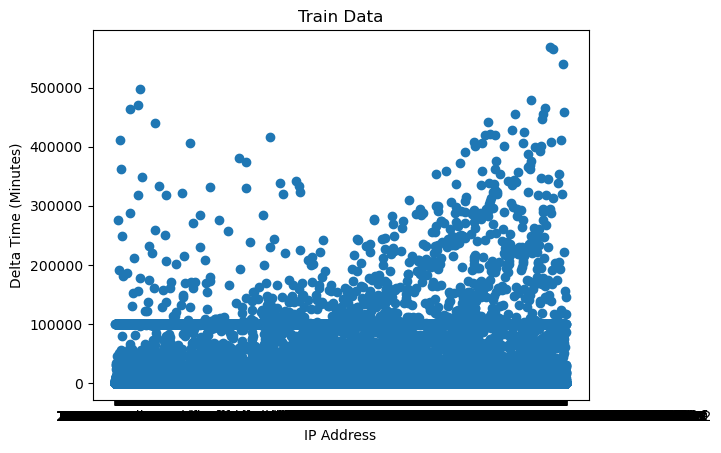

In [21]:
plt.scatter(train_data['IP Address'], train_data['Delta Time (Minutes)'])
plt.xlabel('IP Address')
plt.ylabel('Delta Time (Minutes)')
plt.title('Train Data')
plt.show()

In [22]:
train_features = train_data[features]
test_features = test_data[features]
train_features

,Delta Time (Minutes),Bytes Sent,Status Code,UA_0,UA_1,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9
2,1.066667,665508.0,200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
13,3.600000,176587.0,200,0.500771,0.499507,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470
23,1.000000,665508.0,200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
78,0.016667,0.0,499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
182,0.016667,0.0,499,0.000000,0.000000,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,0.016667,548.0,404,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365303,0.016667,548.0,404,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365323,0.016667,548.0,404,0.516357,0.515053,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923
11365464,0.000000,0.0,301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [23]:
train_features.dtypes

Delta Time (Minutes)    float32
Bytes Sent              float32
Status Code               int64
UA_0                    float32
UA_1                    float32
UA_2                    float32
UA_3                    float32
UA_4                    float32
UA_5                    float32
UA_6                    float32
UA_7                    float32
UA_8                    float32
UA_9                    float32
dtype: object

In [24]:
eps = 0.3
min_samples = 10

scaler = StandardScaler()
features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

output_file = "dbscan_results_80_20.csv"

clusters = np.zeros(len(features_scaled), dtype=int) 

chunk_size = 100000
num_chunks = (len(features_scaled) + chunk_size - 1) // chunk_size

dbscan = DBSCAN(eps=eps, min_samples=min_samples)

with tqdm(total=len(features_scaled), desc="Processing DBSCAN", unit="samples") as pbar:
    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(features_scaled))
        chunk_cluster = dbscan.fit_predict(features_scaled[start:end])
        clusters[start:end] = chunk_cluster
        pbar.update(end - start)

results = pd.DataFrame({
    'Index': range(len(features_scaled)),
    'Cluster': clusters
})

results.to_csv(output_file, index=False, header=True)

Processing DBSCAN: 100%|██████████| 400000/400000 [02:23<00:00, 2789.19samples/s]


In [25]:
results = pd.read_csv(output_file)
train_data['Cluster'] = results.sort_values('Index')['Cluster'].values

train_data['Not Suspicious'] = train_data['Cluster'] == -1

In [26]:
noise = train_data[train_data['Not Suspicious']]['IP Address'].value_counts()
noise

IP Address
10.220.5.92        151
139.99.89.26        85
10.200.7.2          56
66.70.160.198       36
192.53.117.16       28
                  ... 
180.253.160.24       1
35.203.210.222       1
103.149.120.205      1
103.148.25.244       1
61.147.15.65         1
Name: count, Length: 3386, dtype: int64

In [27]:
train_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
13,66.249.79.63,IPv4,2022-12-16 17:07:46+07:00,GET /webinar-epic-culture-programs-program/ HT...,200,176587.0,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Smartphone,0 days 00:03:36,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,1,False
23,10.220.34.198,IPv4,2022-12-16 17:10:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
78,10.220.34.199,IPv4,2022-12-16 17:11:36+07:00,GET /pendataan-pengiriman-jas-almamater/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/pendataan-pengirima...,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
182,10.220.34.199,IPv4,2022-12-16 17:13:49+07:00,GET /layanan-kemahasiswaan-dan-alumni/organisa...,499,0.0,https://ittelkom-sby.ac.id/layanan-kemahasiswa...,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,10.220.5.92,IPv4,2024-09-17 06:33:19+07:00,GET /dragonforce.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365303,10.220.5.92,IPv4,2024-09-17 06:33:26+07:00,GET /antek.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365323,10.220.5.92,IPv4,2024-09-17 06:33:57+07:00,GET /use.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365464,10.220.5.92,IPv4,2024-09-17 07:17:07+07:00,GET / HTTP/1.0,301,0.0,NaN,Mozilla/5.0 (compatible; YaK/1.0; http://linkf...,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5,False


In [28]:
Check = train_data[train_data['Not Suspicious'] == True]
Check

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
1187,45.77.23.81,IPv4,2022-12-16 19:41:02+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKi...,PC,99999,...,0.296131,0.309851,0.284293,0.296122,0.294687,0.000000,0.301745,0.296338,-1,True
1634,205.196.223.27,IPv4,2022-12-16 20:35:25+07:00,GET /wp-content/uploads/2021/05/wp-login.php H...,404,548.0,ittelkom-sby.ac.id,Mozilla/5.1 (Windows NT 6.0; WOW64) AppleWebKi...,PC,99999,...,0.296131,0.309851,0.284293,0.296122,0.294687,0.000000,0.301745,0.296338,-1,True
1820,66.249.79.63,IPv4,2022-12-16 21:24:00+07:00,GET /wp-content/uploads/2022/12/TeknikTelekomu...,200,3913549.0,NaN,Googlebot/2.1 (+http://www.google.com/bot.html),PC,0 days 00:11:08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,True
2108,182.2.68.103,IPv4,2022-12-16 22:57:47+07:00,GET /wp-content/uploads/2022/12/Informatika.pd...,206,1228479.0,https://ittelkom-sby.ac.id/informatika,Mozilla/5.0 (Linux; Android 11; V2118) AppleWe...,Smartphone,0 days 00:00:10,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,-1,True
2109,182.2.68.103,IPv4,2022-12-16 22:57:47+07:00,GET /wp-content/uploads/2022/12/Informatika.pd...,200,3983037.0,https://ittelkom-sby.ac.id/informatika,Mozilla/5.0 (Linux; Android 11; V2118) AppleWe...,Smartphone,0 days 00:00:00,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,-1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11338415,10.220.5.92,IPv4,2024-09-14 17:34:56+07:00,GET / HTTP/1.0,301,0.0,NaN,\x22Mozilla/5.0 (X11; Linux x86_64; rv:91.0) G...,PC,0 days 00:00:00,...,0.000000,0.000000,0.595192,0.000000,0.000000,0.803583,0.000000,0.000000,-1,True
11339761,10.220.5.92,IPv4,2024-09-14 19:42:35+07:00,GET /php.ini HTTP/1.0,200,227.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:00,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,-1,True
11351416,10.220.5.92,IPv4,2024-09-16 11:09:45+07:00,GET /index.php?option=com_installer&view=archi...,200,177138.0,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,PC,0 days 00:00:05,...,0.251718,0.263380,0.241655,0.251709,0.250490,0.000000,0.256489,0.251893,-1,True
11351882,10.220.5.92,IPv4,2024-09-16 11:22:22+07:00,GET /overlord.php HTTP/1.0,404,146.0,NaN,Mozilla/5.0 (X11; Ubuntu; Linux x86_64) AppleW...,PC,0 days 00:00:00,...,0.361988,0.000000,0.347517,0.361976,0.360222,0.469192,0.368850,0.362241,-1,True


In [29]:
Check_F = train_data[train_data['Not Suspicious'] == False]
Check_F

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
13,66.249.79.63,IPv4,2022-12-16 17:07:46+07:00,GET /webinar-epic-culture-programs-program/ HT...,200,176587.0,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Smartphone,0 days 00:03:36,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,1,False
23,10.220.34.198,IPv4,2022-12-16 17:10:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
78,10.220.34.199,IPv4,2022-12-16 17:11:36+07:00,GET /pendataan-pengiriman-jas-almamater/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/pendataan-pengirima...,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
182,10.220.34.199,IPv4,2022-12-16 17:13:49+07:00,GET /layanan-kemahasiswaan-dan-alumni/organisa...,499,0.0,https://ittelkom-sby.ac.id/layanan-kemahasiswa...,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,10.220.5.92,IPv4,2024-09-17 06:33:19+07:00,GET /dragonforce.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365303,10.220.5.92,IPv4,2024-09-17 06:33:26+07:00,GET /antek.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365323,10.220.5.92,IPv4,2024-09-17 06:33:57+07:00,GET /use.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365464,10.220.5.92,IPv4,2024-09-17 07:17:07+07:00,GET / HTTP/1.0,301,0.0,NaN,Mozilla/5.0 (compatible; YaK/1.0; http://linkf...,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5,False


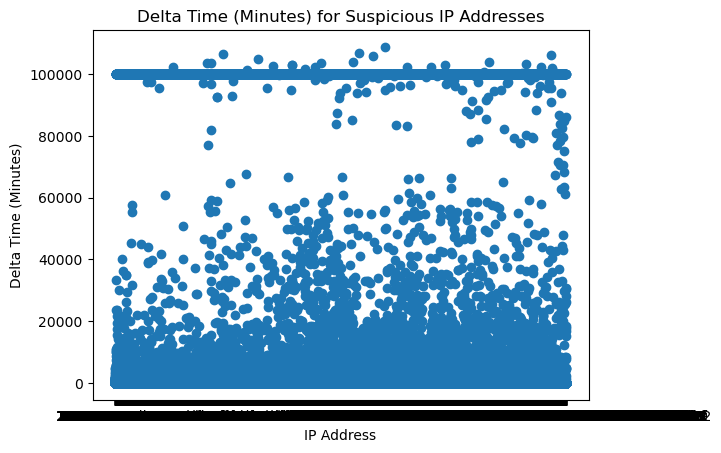

In [30]:
plt.scatter(Check_F['IP Address'], Check_F['Delta Time (Minutes)'])
plt.xlabel('IP Address')
plt.ylabel('Delta Time (Minutes)')
plt.title('Delta Time (Minutes) for Suspicious IP Addresses')
plt.show()

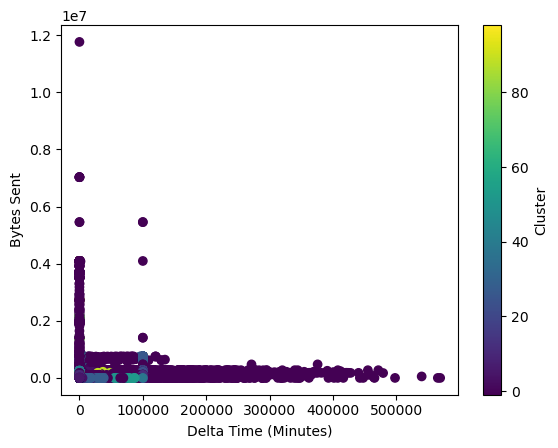

In [31]:
plt.scatter(train_data['Delta Time (Minutes)'], train_data['Bytes Sent'], c=train_data['Cluster'], cmap='viridis')
plt.xlabel('Delta Time (Minutes)')
plt.ylabel('Bytes Sent')
plt.colorbar(label='Cluster')
plt.show()

In [32]:
check_cluster = train_data['Cluster'].unique()
check_cluster

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, -1, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 97, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 83, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 80, 58, 59, 60, 61, 62, 63,
       64, 89, 65, 81, 66, 67, 68, 69, 74, 70, 71, 72, 73, 75, 76, 77, 78,
       79, 82, 84, 85, 86, 87, 88, 90, 91, 92, 95, 93, 94, 96, 98],
      dtype=int64)

In [33]:
cluster_groups = train_data.groupby('Cluster')

In [34]:
for cluster_id, group in cluster_groups:
    if cluster_id == -1:
        continue
    
    print(f"Cluster: {cluster_id}")
    print(f"Jumlah Permintaan: {len(group)}")
    print(f"Jumlah IP Unik: {group['IP Address'].nunique()}")
    print(f"Frekuensi Permintaan:\n{group['Timestamp'].value_counts().head()}")
    print(f"Kode Status Unik: {group['Status Code'].value_counts()}")
    print("-" * 40)

Cluster: 0
Jumlah Permintaan: 31655
Jumlah IP Unik: 2887
Frekuensi Permintaan:
Timestamp
2023-07-13 15:36:53+07:00    4
2023-06-28 03:49:13+07:00    4
2023-12-04 01:52:56+07:00    3
2023-09-09 22:38:19+07:00    3
2023-09-09 01:19:20+07:00    3
Name: count, dtype: int64
Kode Status Unik: Status Code
200    29527
404     2128
Name: count, dtype: int64
----------------------------------------
Cluster: 1
Jumlah Permintaan: 26612
Jumlah IP Unik: 5182
Frekuensi Permintaan:
Timestamp
2023-06-02 02:46:04+07:00    5
2023-03-25 20:33:53+07:00    4
2023-02-21 19:50:24+07:00    4
2023-03-03 06:12:33+07:00    4
2023-08-26 17:50:58+07:00    4
Name: count, dtype: int64
Kode Status Unik: Status Code
200    24325
404     2205
206       82
Name: count, dtype: int64
----------------------------------------
Cluster: 2
Jumlah Permintaan: 29852
Jumlah IP Unik: 1248
Frekuensi Permintaan:
Timestamp
2023-11-12 23:43:38+07:00    4
2023-03-14 14:02:22+07:00    3
2023-10-07 15:54:03+07:00    3
2023-02-27 12:32:34

In [35]:
suspicious_clusters = []

for cluster_id, group in cluster_groups:
    if cluster_id == -1:
        continue
    
    total_requests = len(group)
    unique_ip = group['IP Address'].nunique()
    error_rate = group['Status Code'].value_counts(normalize=True).get(404, 0)

    if total_requests > 60 or unique_ip < 5 or error_rate > 0.5:
        suspicious_clusters.append(cluster_id)

print(f"Cluster mencurigakan: {suspicious_clusters}")

Cluster mencurigakan: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 81, 82, 83, 84, 86, 87, 90, 92, 93, 94, 96, 98]


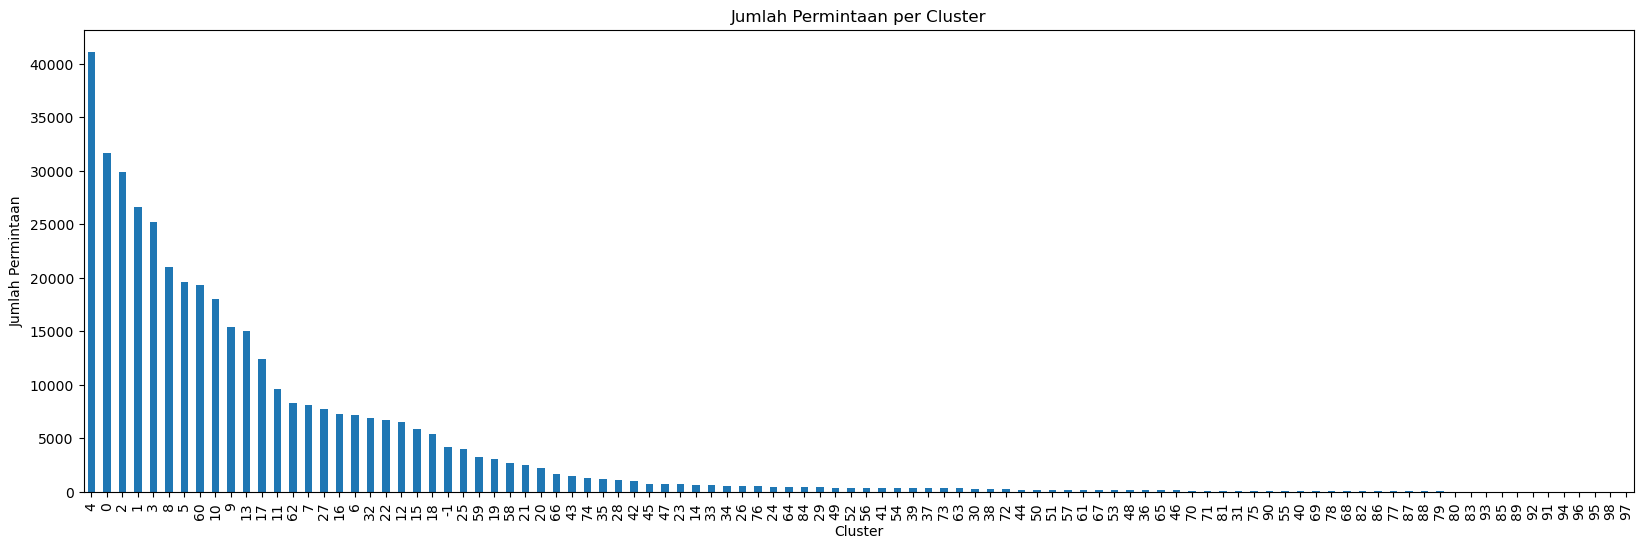

In [36]:
cluster_counts = train_data['Cluster'].value_counts()
cluster_counts.plot(kind='bar', figsize=(20, 6))
plt.title("Jumlah Permintaan per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Permintaan")
plt.show()

In [37]:
cluster_requests = train_data[train_data['Cluster'] != -1].groupby('Cluster').size()

threshold = np.percentile(cluster_requests, 90)

anomalous_clusters = cluster_requests[cluster_requests > threshold]

print("Cluster dengan jumlah request tinggi (anomali):")
anomalous_clusters

Cluster dengan jumlah request tinggi (anomali):


Cluster
0     31655
1     26612
2     29852
3     25187
4     41090
5     19602
8     20967
9     15409
10    18055
60    19302
dtype: int64

In [38]:
train_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
13,66.249.79.63,IPv4,2022-12-16 17:07:46+07:00,GET /webinar-epic-culture-programs-program/ HT...,200,176587.0,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Smartphone,0 days 00:03:36,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,1,False
23,10.220.34.198,IPv4,2022-12-16 17:10:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
78,10.220.34.199,IPv4,2022-12-16 17:11:36+07:00,GET /pendataan-pengiriman-jas-almamater/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/pendataan-pengirima...,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
182,10.220.34.199,IPv4,2022-12-16 17:13:49+07:00,GET /layanan-kemahasiswaan-dan-alumni/organisa...,499,0.0,https://ittelkom-sby.ac.id/layanan-kemahasiswa...,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,10.220.5.92,IPv4,2024-09-17 06:33:19+07:00,GET /dragonforce.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365303,10.220.5.92,IPv4,2024-09-17 06:33:26+07:00,GET /antek.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365323,10.220.5.92,IPv4,2024-09-17 06:33:57+07:00,GET /use.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365464,10.220.5.92,IPv4,2024-09-17 07:17:07+07:00,GET / HTTP/1.0,301,0.0,NaN,Mozilla/5.0 (compatible; YaK/1.0; http://linkf...,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5,False


In [39]:
anomalous_data = train_data[train_data['Cluster'].isin(anomalous_clusters.index)]
anomalous_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
2,10.220.34.198,IPv4,2022-12-16 17:05:16+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
13,66.249.79.63,IPv4,2022-12-16 17:07:46+07:00,GET /webinar-epic-culture-programs-program/ HT...,200,176587.0,NaN,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,Smartphone,0 days 00:03:36,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,1,False
23,10.220.34.198,IPv4,2022-12-16 17:10:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,False
78,10.220.34.199,IPv4,2022-12-16 17:11:36+07:00,GET /pendataan-pengiriman-jas-almamater/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/pendataan-pengirima...,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
182,10.220.34.199,IPv4,2022-12-16 17:13:49+07:00,GET /layanan-kemahasiswaan-dan-alumni/organisa...,499,0.0,https://ittelkom-sby.ac.id/layanan-kemahasiswa...,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11365299,10.220.5.92,IPv4,2024-09-17 06:33:19+07:00,GET /dragonforce.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365303,10.220.5.92,IPv4,2024-09-17 06:33:26+07:00,GET /antek.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365323,10.220.5.92,IPv4,2024-09-17 06:33:57+07:00,GET /use.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,4,False
11365464,10.220.5.92,IPv4,2024-09-17 07:17:07+07:00,GET / HTTP/1.0,301,0.0,NaN,Mozilla/5.0 (compatible; YaK/1.0; http://linkf...,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5,False


In [40]:
anomalous_data['Request Cluster Anomali'] = anomalous_data.groupby('IP Address')['Timestamp'].diff().fillna(pd.Timedelta(seconds=0))

threshold_time = pd.Timedelta(seconds=5)

frequent_requests = anomalous_data[anomalous_data['Request Cluster Anomali'] < threshold_time]

frequent_requests_ip = frequent_requests.groupby('IP Address').size()

ddos_time_based_ips = frequent_requests_ip[frequent_requests_ip > 5]

print("IP dengan permintaan tinggi dalam waktu singkat (potensi DDoS):")
ddos_time_based_ips

IP dengan permintaan tinggi dalam waktu singkat (potensi DDoS):


IP Address
10.200.7.2           146
10.220.34.198         11
10.220.34.199       1168
10.220.5.92        25718
103.138.192.109      281
                   ...  
91.92.250.191          9
91.92.254.247         10
92.223.85.198          8
92.223.85.69           9
93.185.162.24         23
Length: 253, dtype: int64

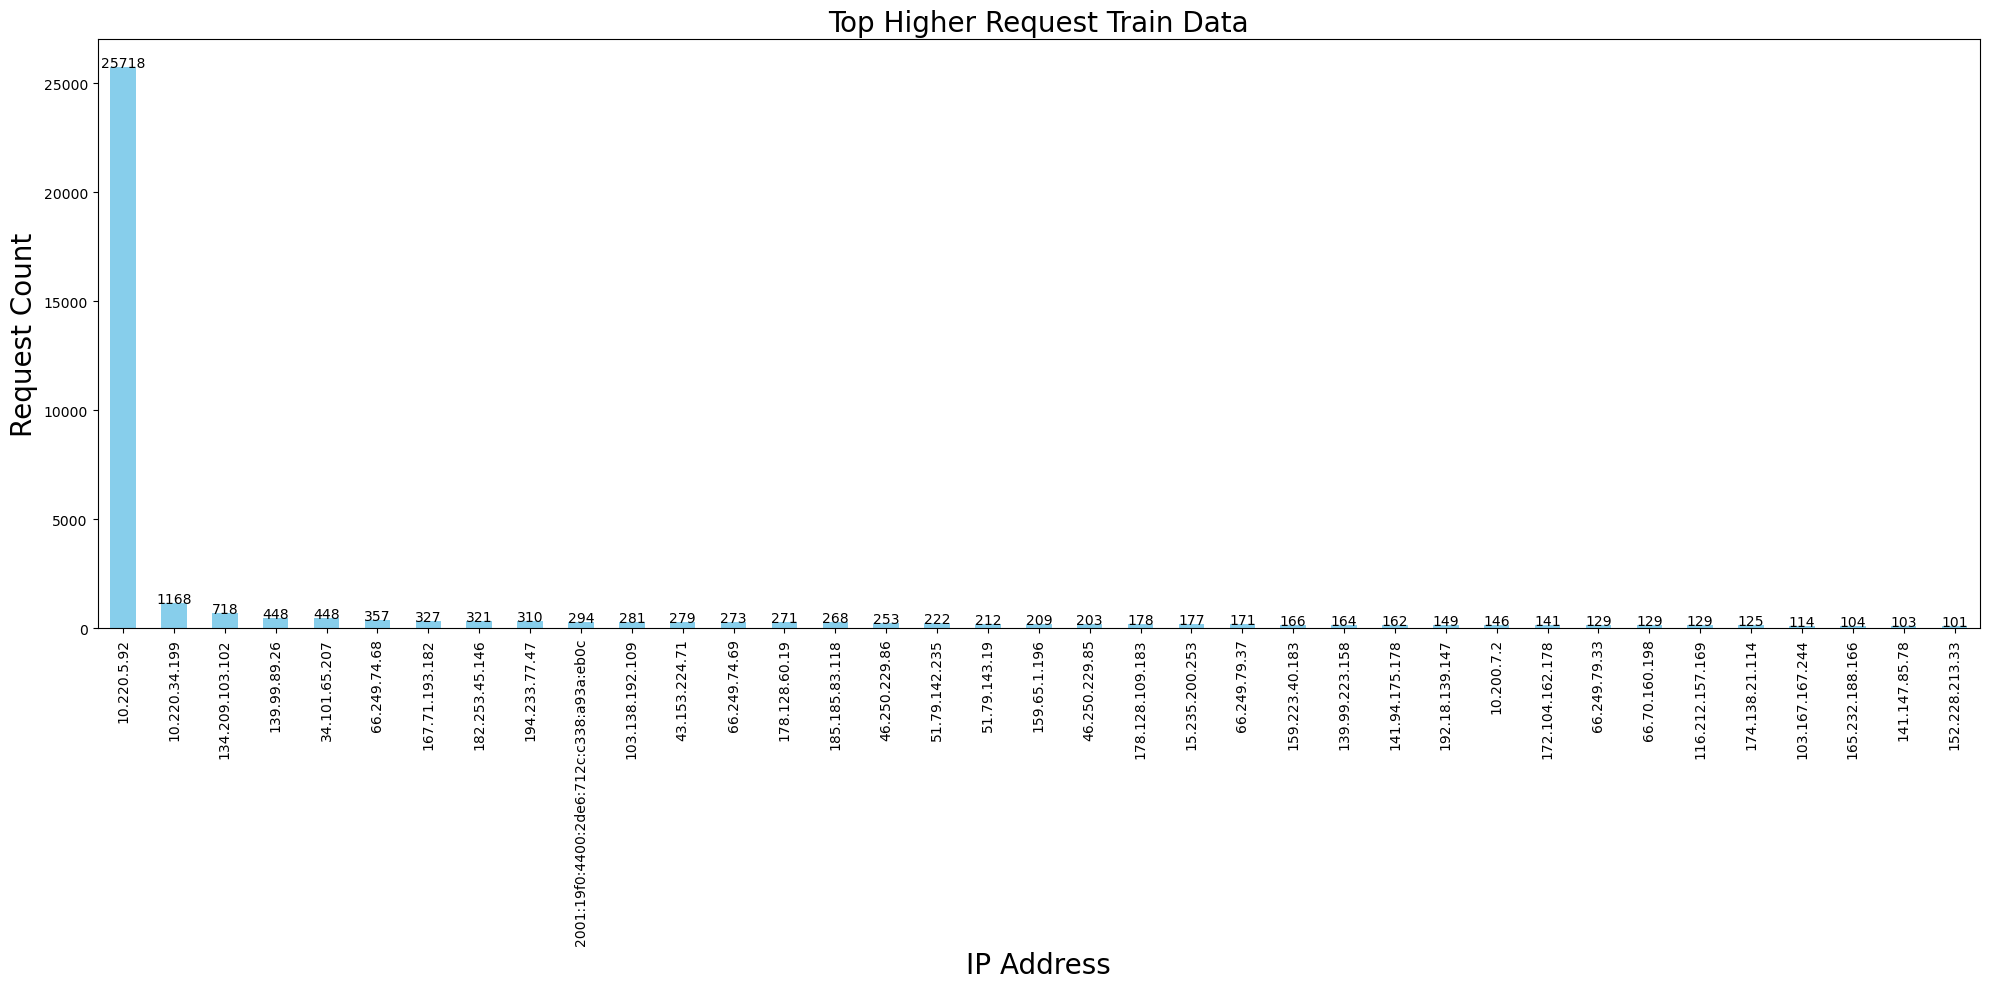

In [41]:
filtered_ddos_ips_test = ddos_time_based_ips[ddos_time_based_ips > 100]

top_ddos_ips_train = filtered_ddos_ips_test.sort_values(ascending=False)

plt.figure(figsize=(20, 10))
top_ddos_ips_train.plot(kind='bar', color='skyblue')

plt.title("Top Higher Request Train Data", fontsize=20)
plt.xlabel("IP Address", fontsize=20)
plt.ylabel("Request Count", fontsize=20)

for index, value in enumerate(top_ddos_ips_train):
    plt.text(index, value + 2, str(value), ha='center')

plt.tight_layout()
plt.show()

# TESTING

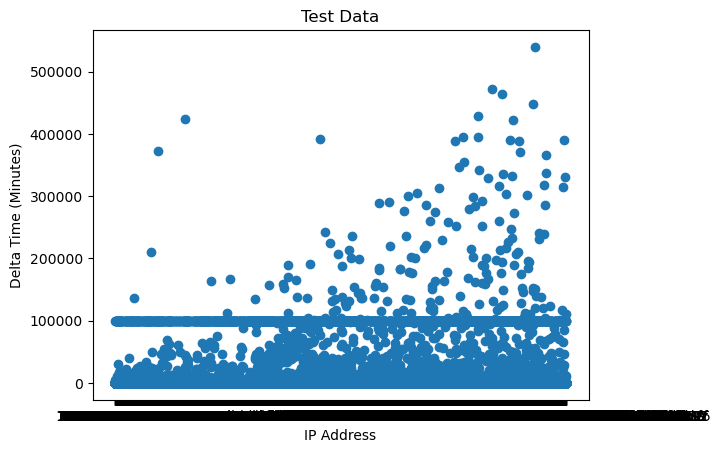

In [42]:
plt.scatter(test_data['IP Address'], test_data['Delta Time (Minutes)'])
plt.xlabel('IP Address')
plt.ylabel('Delta Time (Minutes)')
plt.title('Test Data')
plt.show()

In [43]:
print(test_data.dtypes)

IP Address                                 object
IP Type                                    object
Timestamp               datetime64[ns, UTC+07:00]
Request                                    object
Status Code                                 int64
Bytes Sent                                float32
Referrer                                   object
User Agent                                 object
Device                                     object
Delta Time                                 object
Delta Time (Minutes)                      float32
UA_0                                      float32
UA_1                                      float32
UA_2                                      float32
UA_3                                      float32
UA_4                                      float32
UA_5                                      float32
UA_6                                      float32
UA_7                                      float32
UA_8                                      float32


In [44]:
print(test_data.isna().sum())

IP Address                  0
IP Type                     0
Timestamp                   0
Request                     0
Status Code                 0
Bytes Sent                  0
Referrer                65153
User Agent                  0
Device                      0
Delta Time                  0
Delta Time (Minutes)        0
UA_0                        0
UA_1                        0
UA_2                        0
UA_3                        0
UA_4                        0
UA_5                        0
UA_6                        0
UA_7                        0
UA_8                        0
UA_9                        0
dtype: int64


In [45]:
print(test_features[:5])

     Delta Time (Minutes)  Bytes Sent  Status Code      UA_0      UA_1  \
75               0.016667         0.0          499  0.000000  0.000000   
185              0.016667         0.0          499  0.000000  0.000000   
277              0.000000        12.0          200  0.000000  0.000000   
302              0.016667     92444.0          200  0.500771  0.499507   
507              1.000000    665508.0          200  0.000000  0.000000   

         UA_2     UA_3      UA_4      UA_5      UA_6      UA_7      UA_8  \
75   0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
185  0.334781  0.00000  0.321398  0.334770  0.666296  0.000000  0.341127   
277  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
302  0.239303  0.25039  0.229737  0.239295  0.238136  0.310173  0.243839   
507  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  1.000000   

         UA_9  
75   0.000000  
185  0.335015  
277  0.000000  
302  0.239470  
507  0.000000  


In [46]:
test_clusters = dbscan.fit_predict(test_features_scaled)
test_data['Cluster'] = test_clusters

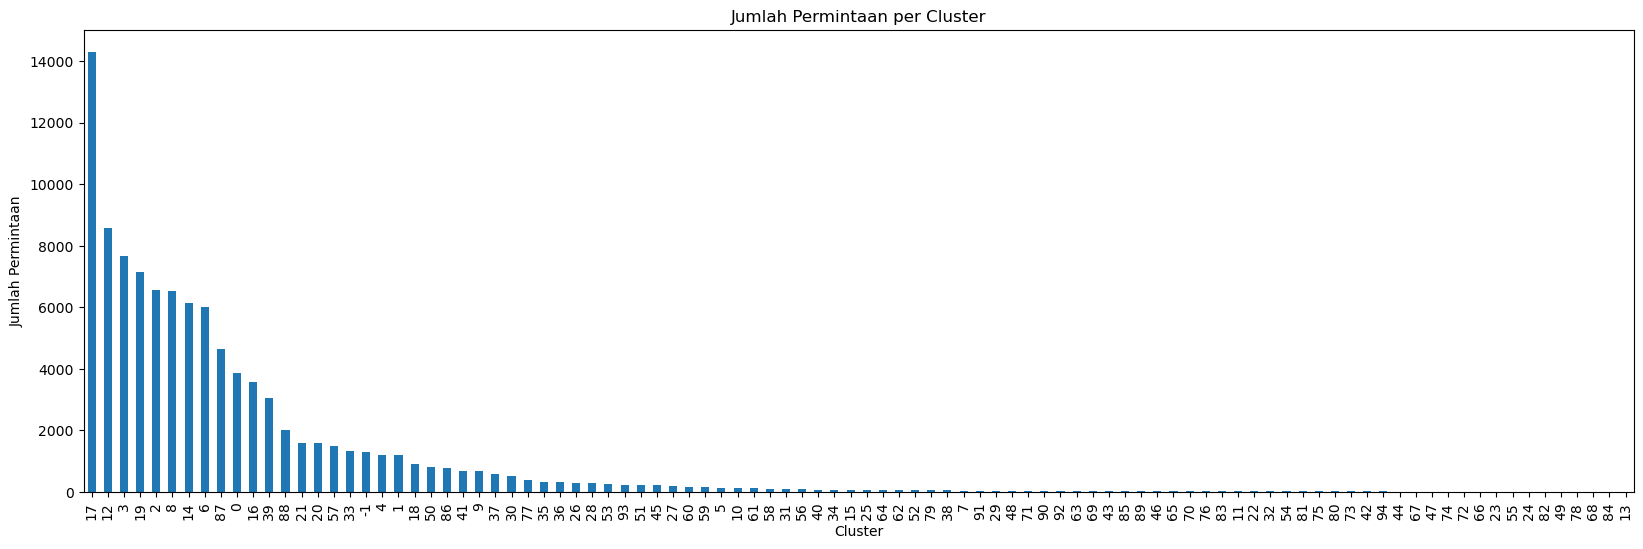

In [47]:
cluster_counts = test_data['Cluster'].value_counts()
cluster_counts.plot(kind='bar', figsize=(20, 6))
plt.title("Jumlah Permintaan per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Permintaan")
plt.show()

In [48]:
check_cluster_test = test_data['Cluster'].unique()
check_cluster_test

array([ 0,  1,  2,  3,  4,  5, -1,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 65, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 49, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 61, 62, 63, 64,
       66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 81, 78, 82, 79, 80, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], dtype=int64)

In [49]:
test_data['Not Suspicious'] = test_data['Cluster'] == -1
test_data

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
75,10.220.34.199,IPv4,2022-12-16 17:11:33+07:00,GET /category/pengumuman/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/category/pengumuman/,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False
185,10.220.34.199,IPv4,2022-12-16 17:13:52+07:00,GET /virtual-tour/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/virtual-tour/,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,1,False
277,10.220.34.199,IPv4,2022-12-16 17:18:45+07:00,POST /wp-admin/admin-ajax.php?action=wordfence...,200,12.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,FyxlAUZCepT3,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
302,180.244.163.1,IPv4,2022-12-16 17:21:34+07:00,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444.0,https://ittelkom-sby.ac.id/kenal-lebih-dalam-p...,Mozilla/5.0 (Linux; Android 6.0; Redmi Note 4X...,Smartphone,0 days 00:00:01,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,3,False
507,10.220.34.198,IPv4,2022-12-16 17:52:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364853,10.220.5.92,IPv4,2024-09-17 06:18:40+07:00,GET /0byte.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:03,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11364883,10.220.5.92,IPv4,2024-09-17 06:19:41+07:00,GET /alfa.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:02,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11365225,10.220.5.92,IPv4,2024-09-17 06:31:22+07:00,GET /defaults.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11365339,10.220.5.92,IPv4,2024-09-17 06:34:27+07:00,GET /h.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False


In [50]:
Check_F_test = test_data[test_data['Not Suspicious'] == False]
Check_F_test

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_2,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious
75,10.220.34.199,IPv4,2022-12-16 17:11:33+07:00,GET /category/pengumuman/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/category/pengumuman/,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False
185,10.220.34.199,IPv4,2022-12-16 17:13:52+07:00,GET /virtual-tour/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/virtual-tour/,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.334781,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,1,False
277,10.220.34.199,IPv4,2022-12-16 17:18:45+07:00,POST /wp-admin/admin-ajax.php?action=wordfence...,200,12.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,FyxlAUZCepT3,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False
302,180.244.163.1,IPv4,2022-12-16 17:21:34+07:00,GET /wp-content/plugins/elementor/assets/lib/e...,200,92444.0,https://ittelkom-sby.ac.id/kenal-lebih-dalam-p...,Mozilla/5.0 (Linux; Android 6.0; Redmi Note 4X...,Smartphone,0 days 00:00:01,...,0.239303,0.250390,0.229737,0.239295,0.238136,0.310173,0.243839,0.239470,3,False
507,10.220.34.198,IPv4,2022-12-16 17:52:13+07:00,GET / HTTP/1.0,200,665508.0,NaN,Mozilla/5.0 (compatible; PRTG Network Monitor ...,PC,0 days 00:01:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364853,10.220.5.92,IPv4,2024-09-17 06:18:40+07:00,GET /0byte.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:03,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11364883,10.220.5.92,IPv4,2024-09-17 06:19:41+07:00,GET /alfa.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:02,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11365225,10.220.5.92,IPv4,2024-09-17 06:31:22+07:00,GET /defaults.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False
11365339,10.220.5.92,IPv4,2024-09-17 06:34:27+07:00,GET /h.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.246751,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False


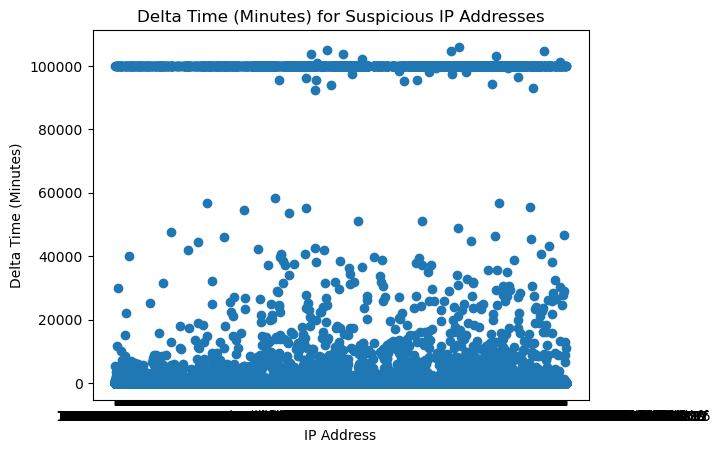

In [51]:
plt.scatter(Check_F_test['IP Address'], Check_F_test['Delta Time (Minutes)'])
plt.xlabel('IP Address')
plt.ylabel('Delta Time (Minutes)')
plt.title('Delta Time (Minutes) for Suspicious IP Addresses')
plt.show()

In [52]:
suspicious_test_clusters = []

for cluster_id, group in test_data.groupby('Cluster'):
    if cluster_id == -1: 
        continue
    
    total_requests = len(group)
    unique_ip = group['IP Address'].nunique()
    error_rate = group['Status Code'].value_counts(normalize=True).get(404, 0)
    
    if total_requests > 60 or unique_ip < 5 or error_rate > 0.5:
        suspicious_test_clusters.append(cluster_id)
    
print(f"Cluster test data mencurigakan: {suspicious_test_clusters}")

Cluster test data mencurigakan: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 47, 50, 51, 53, 55, 56, 57, 58, 59, 60, 61, 64, 68, 71, 75, 76, 77, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]


In [53]:
cluster_requests_test = test_data[test_data['Cluster'] != -1].groupby('Cluster').size()

thresholds = np.percentile(cluster_requests_test, 90)

anomalous_clusters_test = cluster_requests_test[cluster_requests_test > thresholds]

print("Cluster dengan jumlah request tinggi (anomali) di data Test:")
anomalous_clusters_test

Cluster dengan jumlah request tinggi (anomali) di data Test:


Cluster
0      3874
2      6555
3      7661
6      6023
8      6521
12     8580
14     6134
17    14296
19     7139
87     4641
dtype: int64

In [54]:
test_data['Request Cluster Anomali'] = test_data.groupby('IP Address')['Timestamp'].diff().fillna(pd.Timedelta(seconds=0))
frequent_requests_test = test_data[test_data['Request Cluster Anomali'] < pd.Timedelta(seconds=5)]

frequent_requests_ip_test = frequent_requests_test.groupby('IP Address').size()
ddos_time_based_ips_test = frequent_requests_ip_test[frequent_requests_ip_test > 5]

print("IP mencurigakan berdasarkan permintaan tinggi dalam waktu singkat:")
ddos_time_based_ips_test

IP mencurigakan berdasarkan permintaan tinggi dalam waktu singkat:


IP Address
10.200.7.2           13
10.220.34.199       125
10.220.5.92        4161
103.138.192.109      30
103.155.25.241       12
                   ... 
68.183.179.236        6
91.92.247.170         6
91.92.250.191         6
92.223.86.29          6
94.130.164.87         8
Length: 115, dtype: int64

In [55]:
suspicious_ips_test = ddos_time_based_ips_test.index

filtered_data_test = test_data[test_data['IP Address'].isin(suspicious_ips_test)]

filtered_data_test

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious,Request Cluster Anomali
75,10.220.34.199,IPv4,2022-12-16 17:11:33+07:00,GET /category/pengumuman/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/category/pengumuman/,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,0 days 00:00:00
185,10.220.34.199,IPv4,2022-12-16 17:13:52+07:00,GET /virtual-tour/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/virtual-tour/,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,1,False,0 days 00:02:19
277,10.220.34.199,IPv4,2022-12-16 17:18:45+07:00,POST /wp-admin/admin-ajax.php?action=wordfence...,200,12.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,FyxlAUZCepT3,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False,0 days 00:04:53
724,10.220.34.199,IPv4,2022-12-16 18:18:10+07:00,POST /wp-cron.php?doing_wp_cron=1671189490.212...,200,0.0,https://ittelkom-sby.ac.id/wp-cron.php?doing_w...,XEcrm3dGrQHG,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False,0 days 00:59:25
766,10.220.34.199,IPv4,2022-12-16 18:19:08+07:00,POST /wp-admin/admin-ajax.php?action=rocket_pa...,499,0.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,HXJyrqhUSDoi,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,0 days 00:00:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364853,10.220.5.92,IPv4,2024-09-17 06:18:40+07:00,GET /0byte.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:03,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:47:23
11364883,10.220.5.92,IPv4,2024-09-17 06:19:41+07:00,GET /alfa.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:02,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:01:01
11365225,10.220.5.92,IPv4,2024-09-17 06:31:22+07:00,GET /defaults.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:11:41
11365339,10.220.5.92,IPv4,2024-09-17 06:34:27+07:00,GET /h.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:03:05


In [56]:
score_test = silhouette_score(test_features_scaled, test_data['Cluster'])
score_test

0.7171236910646036

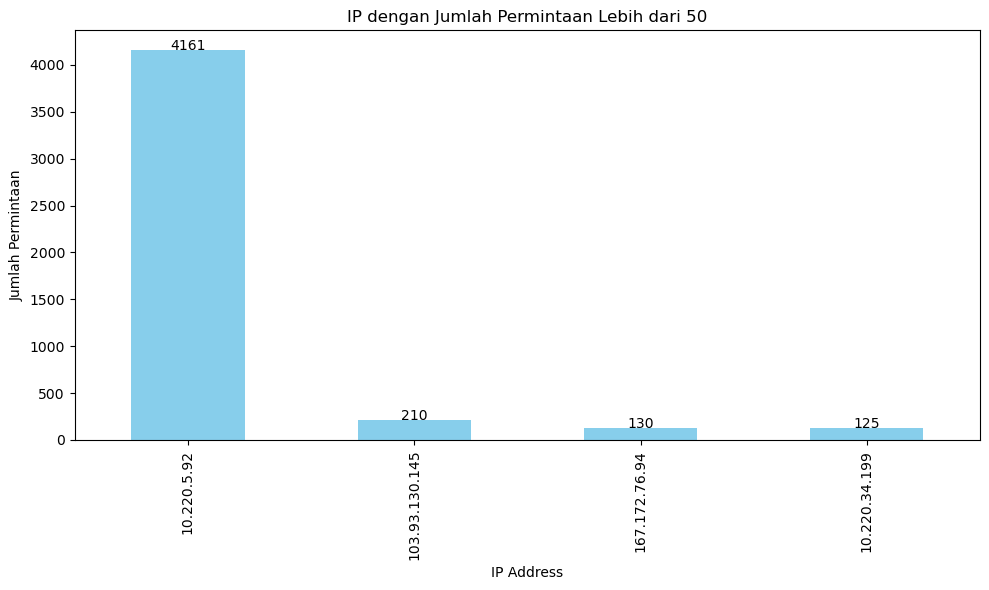

In [57]:
filtered_ddos_ips_test = ddos_time_based_ips_test[ddos_time_based_ips_test > 100]

top_ddos_ips_test = filtered_ddos_ips_test.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
top_ddos_ips_test.plot(kind='bar', color='skyblue')

plt.title("IP dengan Jumlah Permintaan Lebih dari 50")
plt.xlabel("IP Address")
plt.ylabel("Jumlah Permintaan")

for index, value in enumerate(top_ddos_ips_test):
    plt.text(index, value + 2, str(value), ha='center')

plt.tight_layout()
plt.show()

In [58]:
top_ddos_ips_test

IP Address
10.220.5.92       4161
103.93.130.145     210
167.172.76.94      130
10.220.34.199      125
dtype: int64

In [59]:
filtered_data_test_track = test_data[test_data['IP Address'].isin(top_ddos_ips_test.index)]
filtered_data_test_track

,IP Address,IP Type,Timestamp,Request,Status Code,Bytes Sent,Referrer,User Agent,Device,Delta Time,...,UA_3,UA_4,UA_5,UA_6,UA_7,UA_8,UA_9,Cluster,Not Suspicious,Request Cluster Anomali
75,10.220.34.199,IPv4,2022-12-16 17:11:33+07:00,GET /category/pengumuman/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/category/pengumuman/,WP Rocket/Preload,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,0 days 00:00:00
185,10.220.34.199,IPv4,2022-12-16 17:13:52+07:00,GET /virtual-tour/ HTTP/1.0,499,0.0,https://ittelkom-sby.ac.id/virtual-tour/,Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Ma...,Smartphone,0 days 00:00:01,...,0.000000,0.321398,0.334770,0.666296,0.000000,0.341127,0.335015,1,False,0 days 00:02:19
277,10.220.34.199,IPv4,2022-12-16 17:18:45+07:00,POST /wp-admin/admin-ajax.php?action=wordfence...,200,12.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,FyxlAUZCepT3,PC,0 days 00:00:00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False,0 days 00:04:53
724,10.220.34.199,IPv4,2022-12-16 18:18:10+07:00,POST /wp-cron.php?doing_wp_cron=1671189490.212...,200,0.0,https://ittelkom-sby.ac.id/wp-cron.php?doing_w...,XEcrm3dGrQHG,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False,0 days 00:59:25
766,10.220.34.199,IPv4,2022-12-16 18:19:08+07:00,POST /wp-admin/admin-ajax.php?action=rocket_pa...,499,0.0,https://ittelkom-sby.ac.id/wp-admin/admin-ajax...,HXJyrqhUSDoi,PC,0 days 00:00:01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,False,0 days 00:00:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364853,10.220.5.92,IPv4,2024-09-17 06:18:40+07:00,GET /0byte.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:03,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:47:23
11364883,10.220.5.92,IPv4,2024-09-17 06:19:41+07:00,GET /alfa.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:02,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:01:01
11365225,10.220.5.92,IPv4,2024-09-17 06:31:22+07:00,GET /defaults.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:11:41
11365339,10.220.5.92,IPv4,2024-09-17 06:34:27+07:00,GET /h.php HTTP/1.0,404,548.0,www.google.com,Mozlila/5.0 (Linux; Android 7.0; SM-G892A Buli...,Smartphone,0 days 00:00:01,...,0.258183,0.236887,0.246743,0.245547,0.319827,0.000000,0.246923,17,False,0 days 00:03:05


In [60]:
ddos_cluster = filtered_data_test_track[filtered_data_test_track['Cluster'] != -1]['Cluster'].unique()
ddos_cluster

array([ 0,  1,  2, 46, 15, 36, 21, 30, 52, 60,  8, 51, 20, 17, 14, 12, 16,
       57, 33,  6, 39, 19, 18,  9, 35, 53, 76, 64, 48, 40, 84, 69,  5, 77,
       85, 80, 45, 58, 41, 32, 86, 87, 88, 89, 90, 91, 92, 59, 50, 93, 94,
       71,  3, 79, 24, 10], dtype=int64)

In [61]:
filtering_data_test_check_c = filtered_data_test_track[filtered_data_test_track['Cluster'].isin(ddos_cluster)]

request_count_per_cluster = filtering_data_test_check_c.groupby(['Cluster', 'IP Address']).size().reset_index(name='Request Count')

start_end_times = filtering_data_test_check_c.groupby(['Cluster', 'IP Address'])['Timestamp'].agg(['first', 'last']).reset_index()

request_count_per_cluster = request_count_per_cluster.merge(start_end_times, on=['Cluster', 'IP Address'])

request_count_per_cluster


,Cluster,IP Address,Request Count,first,last
0,0,10.220.34.199,3249,2022-12-16 17:11:33+07:00,2023-12-20 07:11:42+07:00
1,0,10.220.5.92,89,2024-05-14 15:39:18+07:00,2024-08-25 16:10:15+07:00
2,0,103.93.130.145,292,2023-10-16 10:01:20+07:00,2023-12-18 11:20:12+07:00
3,1,10.220.34.199,1188,2022-12-16 17:13:52+07:00,2024-01-10 19:12:37+07:00
4,2,10.220.34.199,5550,2022-12-16 17:18:45+07:00,2024-01-10 21:48:00+07:00
...,...,...,...,...,...
71,90,10.220.5.92,35,2024-06-09 15:07:58+07:00,2024-09-12 21:06:42+07:00
72,91,10.220.5.92,46,2024-06-09 18:54:02+07:00,2024-09-05 16:37:19+07:00
73,92,10.220.5.92,34,2024-06-14 18:00:52+07:00,2024-09-10 18:20:03+07:00
74,93,10.220.5.92,236,2024-06-17 15:44:52+07:00,2024-09-11 21:01:05+07:00


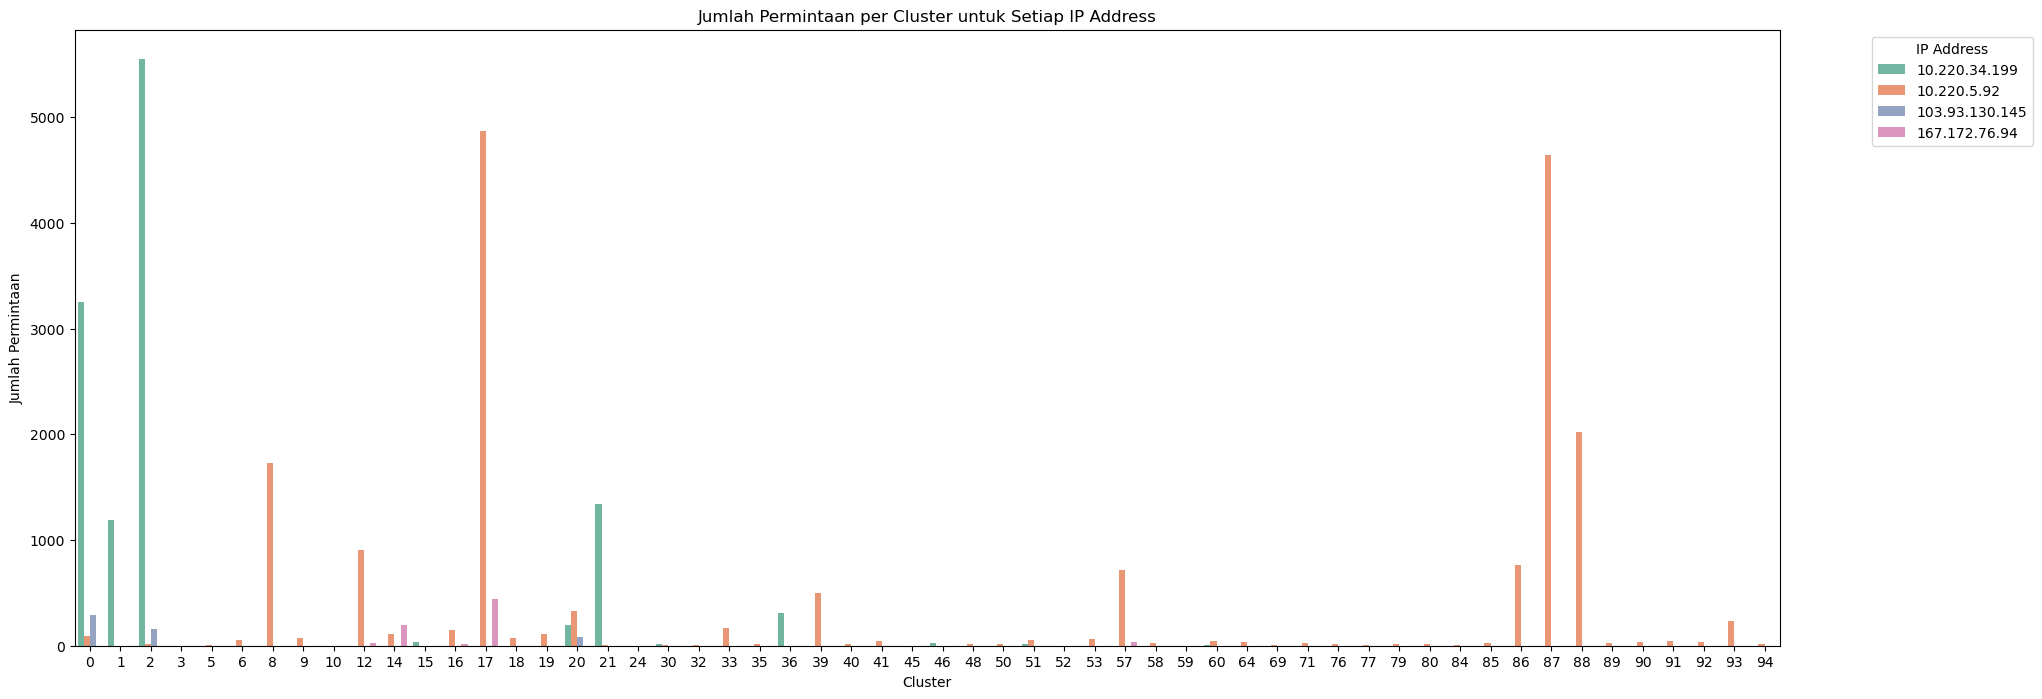

In [62]:
plt.figure(figsize=(22, 8))
sns.barplot(data=request_count_per_cluster, x='Cluster', y='Request Count', hue='IP Address', palette='Set2')

plt.title('Jumlah Permintaan per Cluster untuk Setiap IP Address')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Permintaan')

plt.legend(title='IP Address', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

In [63]:
filtering_data_test = filtered_data_test_track[
    filtered_data_test_track['Cluster'].isin(ddos_cluster) & 
    (filtered_data_test_track['Cluster'] != -1)
]

request_count_per_ip = filtering_data_test.groupby('IP Address').agg(
    Total_Request_Count=('Timestamp', 'size'),
    Interval_Time_start=('Timestamp', 'min'),
    Interval_Time_End=('Timestamp', 'max')
).reset_index()

request_count_per_ip['Attack'] = filtering_data_test.groupby('IP Address')['Cluster'].nunique().reset_index(name='Attack')['Attack']

request_count_per_ip_sorted = request_count_per_ip.sort_values(by='Total_Request_Count', ascending=False)

request_count_per_ip_sorted

,IP Address,Total_Request_Count,Interval_Time_start,Interval_Time_End,Attack
1,10.220.5.92,18182,2024-03-30 16:07:03+07:00,2024-09-17 07:17:01+07:00,52
0,10.220.34.199,11936,2022-12-16 17:11:33+07:00,2024-01-30 02:08:34+07:00,13
3,167.172.76.94,713,2023-05-11 16:41:38+07:00,2023-05-22 02:46:22+07:00,8
2,103.93.130.145,534,2023-09-14 21:04:31+07:00,2024-01-30 12:08:17+07:00,3
